# 4. Bagging algorithms

This notebook will show different examples of bagging algorithms: Bagging, Random Forest and Extra-Trees.
The dataset used for them is [Rain in Australia](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) challenge from Kaggle. It contains about 10 years of daily weather observations from many locations across Australia.

### Index:
1. [Packages required](#1.-Packages-required)
2. [Loading data](#2.-Loading-data)
3. [Bagging](#3.-Bagging)
4. [Random Forest](#4.-Random-Forest)
5. [Extra-Trees](#5.-Extra-Trees)
6. [Conclusions](#6.-Conclusions)

# 1. Packages required

In [5]:
import os
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
import time

# 2. Loading data

In [2]:
weather = pd.read_parquet('../data/04_model_input/master.parquet')
weather.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Temp9am,Temp3pm,RainToday,RainTomorrow,Date_month,Date_day,Location_encoded,WindGustDir_encoded,WindDir9am_encoded,WindDir3pm_encoded
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,16.9,21.8,0,0.0,12,1,2,12.0,12.0,13.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,17.2,24.3,0,0.0,12,2,2,13.0,15.0,11.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,21.0,23.2,0,0.0,12,3,2,11.0,12.0,11.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,18.1,26.5,0,0.0,12,4,2,2.0,6.0,4.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,17.8,29.7,0,0.0,12,5,2,12.0,3.0,14.0


# 3. Bagging

Bagging algorithm works taking training data samples and building different decision trees with each sample. The result of the algorithm is the mean of trees predictions or the most voted class (regresion or classification).

We are interested in running Bagging algorithm on the current dataset and show the results. We will choose train/test data according to an Out-Of-Time validation, with the purpose of knowing how well it works when it has to predict future 'RainTomorrow' values.

Also, we will test it with different numbers of samples and using Decision trees with max_depth = 5, the most efficient value as we can see in the last notebook.

In [3]:
#We fix the variables we are interested in and the date to separate data:
test_date = '2015-01-01'

model_columns = list(set(weather.select_dtypes(include='number').columns) - set(['RainTomorrow']))

In [4]:
#We separate in train/test data and solve Nan problems:
train = weather[weather.Date < test_date].fillna(-1)
test = weather[weather.Date >= test_date].fillna(-1)

In [6]:
#We generate our Bagging algorithms:
tree = DecisionTreeClassifier(max_depth = 5)
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100]:
    start_time = time.time()
    model = BaggingClassifier(base_estimator = tree, n_estimators = n_estimators)
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['Bag_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_bag = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_bag['delta%'] = 100*(metrics_bag.Test_Gini - metrics_bag.Train_Gini) / metrics_bag.Train_Gini
metrics_bag

,Run_Time,Train_Gini,Test_Gini,delta%
Bag_1,0.382962,0.660198,0.633449,-4.051692
Bag_3,0.888438,0.679493,0.647962,-4.640436
Bag_5,1.432807,0.690592,0.663330,-3.947685
Bag_10,2.829983,0.690762,0.662023,-4.160517
Bag_15,4.142565,0.691081,0.663926,-3.929246
Bag_20,5.533969,0.695137,0.669578,-3.676883
Bag_30,8.330249,0.693981,0.666710,-3.929700
Bag_50,13.690714,0.694315,0.668989,-3.647589
Bag_100,27.202286,0.694153,0.669443,-3.559802


# 4. Random Forest

Random Forest algorithm works as Bagging but taking features samples too. The most common number of features is $\sqrt{p}$, where p is the total number of features. So, Random Forest build trees with different rows and different columns and the prediction is the mean of trees predictions or the most voted class (regression or classification).

Now, we are interested in running Random Forest algorithm on the current dataset to know 'RainTomorrow' predictions. We will choose validation data according to the last example. Also, we will compare its efectiveness with different numbers of samples and we will use a Decision tree with max_depth = 5 as base estimator.

In [8]:
#We generate our Random Forest algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100]:
    start_time = time.time()
    model = RandomForestClassifier(n_estimators = n_estimators, max_depth = 5, max_features = 'sqrt')
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['RF_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_RF = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_RF['delta%'] = 100*(metrics_RF.Test_Gini - metrics_RF.Train_Gini) / metrics_RF.Train_Gini
metrics_RF

,Run_Time,Train_Gini,Test_Gini,delta%
RF_1,0.151976,0.593165,0.573133,-3.377129
RF_3,0.254370,0.659192,0.637688,-3.262110
RF_5,0.391759,0.689347,0.667437,-3.178340
RF_10,0.747780,0.698583,0.681952,-2.380700
RF_15,1.036218,0.699125,0.677177,-3.139431
RF_20,1.381562,0.697036,0.671808,-3.619343
RF_30,1.896043,0.700051,0.673814,-3.747798
RF_50,3.117632,0.704250,0.678964,-3.590466
RF_100,6.098359,0.703250,0.679907,-3.319185


# 5. Extra-Trees

Extra-Trees is based on Random Forest. The difference between them is in the way to build the trees: Random Forest separate nodes according to the most efficient partition and Extra Trees fix a random value for each variable and separate nodes according to this random values. Thus, it grants more randomness to the algorithm.

We will repeat the objective: evaluate 'RainTomorrow' predictions that it offers, using Out-Of-Time validation and trees with max_depth = 5.

In [9]:
#We generate our Extra-Trees algorithms:
metrics = {}
for n_estimators in [1, 3, 5, 10, 15, 20, 30, 50, 100]:
    start_time = time.time()
    model = ExtraTreesClassifier(n_estimators = n_estimators, max_depth = 5, max_features = 'sqrt')
    model.fit(train[model_columns],train.RainTomorrow);
    
    train_pred = model.predict_proba(train[model_columns])[:, 1]
    test_pred = model.predict_proba(test[model_columns])[:, 1]

    metrics['ET_'+ str(n_estimators)] = {
        'Train_Gini': 2*roc_auc_score(train.RainTomorrow, train_pred)-1,
        'Test_Gini': 2*roc_auc_score(test.RainTomorrow, test_pred)-1,
        'Run_Time': time.time() - start_time
    }

metrics_ET = pd.DataFrame.from_dict(metrics, orient='index',columns=['Run_Time', 'Train_Gini', 'Test_Gini'])
metrics_ET['delta%'] = 100*(metrics_ET.Test_Gini - metrics_ET.Train_Gini) / metrics_ET.Train_Gini
metrics_ET

,Run_Time,Train_Gini,Test_Gini,delta%
ET_1,0.125849,0.449558,0.452201,0.588014
ET_3,0.166516,0.610167,0.583074,-4.440139
ET_5,0.236212,0.651553,0.629674,-3.357846
ET_10,0.374098,0.632385,0.608653,-3.752800
ET_15,0.535496,0.649461,0.626968,-3.463344
ET_20,0.736697,0.642596,0.619433,-3.604516
ET_30,1.043385,0.647908,0.625048,-3.528198
ET_50,1.659489,0.653280,0.629658,-3.615804
ET_100,3.272801,0.660244,0.639050,-3.209971


# 6. Conclusions

As we can see, using bagging algorithms is a good way to reduce variance and avoid overfitting. Comparing the results with the Decision Tree example, with max_depth = 5 we had:

Train_Gini = 0.655905

Test_Gini = 0.626416

delta% = -4.496019

Comparing with our new results, all of these indicators are improved with any of the methods explained in this notebook.

Also, we will show that the number of estimators is not relevant. As we can see, in bagging methods, Gini coefficient converges. Thus, there's no reason to generate lots of estimators, because we won't increase the model's accuracy.

<AxesSubplot:title={'center':'Test'}, xlabel='Number of estimators', ylabel='Gini'>

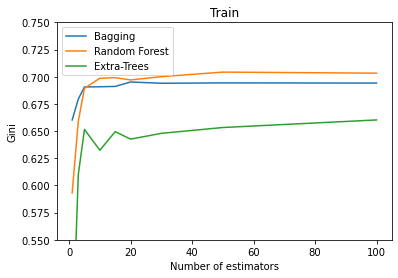

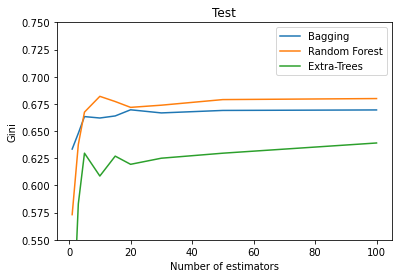

In [10]:
GINITRAIN = pd.DataFrame({'Bagging': list(metrics_bag.Train_Gini.values),
              'Random Forest': list(metrics_RF.Train_Gini.values), 
              'Extra-Trees': list(metrics_ET.Train_Gini.values)}, index = [1, 3, 5, 10, 15, 20, 30, 50, 100])

GINITEST = pd.DataFrame({'Bagging': list(metrics_bag.Test_Gini.values),
              'Random Forest': list(metrics_RF.Test_Gini.values), 
              'Extra-Trees': list(metrics_ET.Test_Gini.values)}, index = [1, 3, 5, 10, 15, 20, 30, 50, 100])

GINITRAIN.plot(ylim = [0.55,0.75], xlabel = 'Number of estimators', ylabel = 'Gini', title = 'Train')
GINITEST.plot(ylim = [0.55,0.75], xlabel = 'Number of estimators', ylabel = 'Gini', title = 'Test')